In [315]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import math
import math
import pydicom
import nibabel as nib
import torch
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import dosma
from dosma.data_io.dicom_io import DicomReader
from dosma.data_io.med_volume import MedicalVolume
from dosma.data_io.nifti_io import NiftiReader

sys.path.append('/home/vanveen/ConvDecoder/')
from include.mri_helpers import generate_t2_map

In [221]:
def get_file_list(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

def get_cartilage(mask):
    ''' given a mask on [0..5] corresponding to different tissue types
        return a mask on [0..1] s.t. pixel is 1 if cartilage, 0 otw '''
    
    mask[mask>4] = 0
    mask[mask!=0] = 1
    
    return mask

def plot_list(arr_list, title_list, clim=(0,1)):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(10,10))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

### overview
- i've recon'ed 20 axial slices of (512, 160). compare t2_map(recon) vs t2_map(gt) on e1, e2
    - for file_id's ['005', '006', '030', '034']

### notes
- mask is a (512, 512, 160) int array w values [0..6]
- each dcm in `/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/` alternates b/w t1, t2
    - that's why te alternates b/w [.006, .034]
    - dimn then makes sense, we have 320/2 = 160 slices of 512x512 each
    - - between slices of a scan, (tr, te) values are the same
    - note te varies if echo1 or echo2
    - across different scans, (tr, te) vary slightly. for now, just accept the constant values
    - why use te value from echo1 as default val?
- dosma code, e.g. in `qdess.py` or `med_volume.py`
    - `t2_map_wrapped = T2(t2_map_wrapped)` step is irrelevant
    - `tissue.add_quantitative_value(t2_map_wrapped)` step is irrelevant - adds the t2_map attribute to input tissue
    
### issue
- nifti seg masks have six classes of tissue in addition to 0's, hence [0..6]
- .h5 seg masks have five classes of tissue in addition to 0's, hence [0..5]
- arjun said for analysis they often group medial/lateral meniscus, i.e. classes 5/6, into one. 
- perhaps the .h5 files have both 5/6 saved as five? check this by bincounting

### TODO
- check on issue
- ask why we use te value from echo1 as default val? why not te from echo2?
- wait for akshay feedback re comparing t2 maps

### load gt, mask as MedicalVolume

In [272]:
file_id = '006'

path_dcm_test = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/MTR_{}/'.format(file_id)
path_m_test = '/bmrNAS/people/arjun/data/qdess_knee_2020/image_files/MTR_{}.h5'.format(file_id)
path_segs = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/masks/MTR_{}.nii.gz'.format(file_id)

volumes = DicomReader().load(path_dcm_test)
echo1 = volumes[0]  # This is a MedicalVolume
echo2 = volumes[1]

mask_nifti = NiftiReader().load(path_segs)

with h5py.File(path_m_test, "r") as f:
    mask_vol_only = f["seg"][()]
    
# what does this line actually do? w/o it, only returns [0,1]'s
mask_vol_only = np.argmax(mask_vol_only, -1) 

mask = MedicalVolume(mask_vol_only, mask_nifti.affine)

mask = mask.reformat(echo1.orientation)

### get central axial volumes

### properly orient mask and cast to [0,1]

In [273]:
# indices to isolate central axial volumes per dd+ recons
IDX_SLICE_MIN = 246
IDX_SLICE_MAX = 266

e1_gt = echo1.volume[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]
e2_gt = echo2.volume[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]

# note: must rotate/flip before cropping
mask_ = mask.volume
mask_ = get_cartilage(mask_) # get binary mask of all cartilage tissue
mask_ = np.rot90(mask_, k=3, axes=(0,1))
mask_ = np.fliplr(mask_)
mask_ = mask_[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]

### load dc volume

### slice-wise normaliz'n s.t. each recon axial slice has same pixel range as gt

In [274]:
slice_idx_list = np.arange(IDX_SLICE_MIN, IDX_SLICE_MAX)

path_dd = '/bmrNAS/people/dvv/out_qdess/accel_4x/echo_joint/specific_slices/'
# file_list_dd = get_file_list(path_dd)
    
vol_shape = (IDX_SLICE_MAX-IDX_SLICE_MIN, 512, 160)
e1_dc, e2_dc = np.empty(vol_shape), np.empty(vol_shape)

for idx_s, slice_idx in enumerate(slice_idx_list):

    fn_e1 = 'MTR_{}_e1_dc_slice{}.npy'.format(file_id, slice_idx)
    fn_e2 = 'MTR_{}_e2_dc_slice{}.npy'.format(file_id, slice_idx)

    e1_dc[idx_s] = np.load(path_dd + fn_e1)
    e2_dc[idx_s] = np.load(path_dd + fn_e2)
    
    
for idx_s in np.arange(len(e1_gt)):
    
    # get slices
    s1_dc, s1_gt = e1_dc[idx_s], e1_gt[idx_s]
    s2_dc, s2_gt = e2_dc[idx_s], e2_gt[idx_s]
    
    # apply normaliz'n
    s1_dc_rng = s1_dc.max() - s1_dc.min()
    e1_dc[idx_s] = (s1_dc - s1_dc.min()) * (s1_gt.max() / s1_dc_rng)
    s2_dc_rng = s2_dc.max() - s2_dc.min()
    e2_dc[idx_s] = (s2_dc - s2_dc.min()) * (s2_gt.max() / s2_dc_rng)

### compute t2 maps, apply mask

In [275]:
t2_map_dc, stats_dc = generate_t2_map(e1_dc, e2_dc)
t2_map_gt, stats_gt = generate_t2_map(e1_gt, e2_gt)

t2_map_gt = mask_ * t2_map_gt
t2_map_dc = mask_ * t2_map_dc

### compare t2 maps

In [421]:
def plot_list_t2(arr_list, title_list, clim=None):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    IDX_SLICE = 10
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        plt.imshow(arr_list[idx][0][IDX_SLICE], cmap='gray', clim=None, aspect=1./SF)
        ii = plt.imshow(arr_list[idx][1][IDX_SLICE], cmap='jet', alpha=0.3, clim=None, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size=.5, pad=.1)
        plt.colorbar(ii, cax=cax)
#         ax.set_aspect('auto')
        ax.axis('off')

In [422]:
t2_map_diff = abs(t2_map_dc - t2_map_gt)
t2_map_diff.min(), t2_map_diff.max()

(0.0, 90.0)

<Figure size 1440x1440 with 0 Axes>

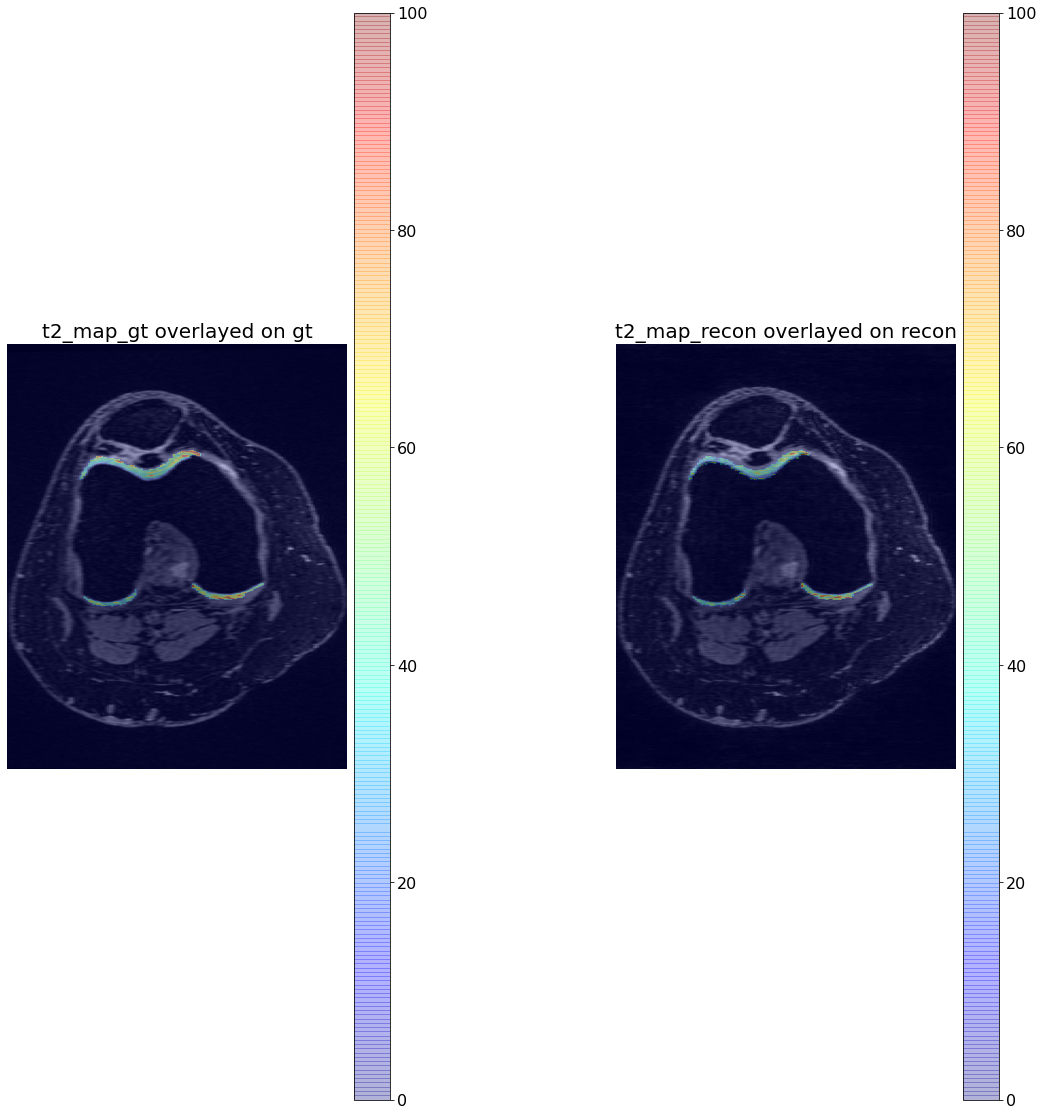

In [431]:
for idx in np.arange(e1_dc.shape[0]):
    
    if idx % 20 == 0:
        
        fig = plt.figure(figsize=(20,20))

        plot_list_t2([[e1_gt, t2_map_gt], [e1_dc, t2_map_dc]], 
                     title_list=['t2_map_gt overlayed on gt', \
                                 't2_map_recon overlayed on recon',])
        
#         plt.imshow(e1_gt[idx], cmap='gray', aspect=1./2.56)
#         plt.imshow(t2_map_diff[idx], cmap='jet', alpha=0.2, aspect=1./2.56)
#         plt.title('abs(diff(t2_map_recon, t2_map_gt)) overlayed on gt', fontsize=32)
#         plt.colorbar()
#         plt.axis('off')

        plt.show()

# OLD

### check to see if masks align w tissue

- to get numpy array from MedicalVolume a, use a.volume

(512, 512, 160)
(512, 512, 160)
(512, 512, 160)


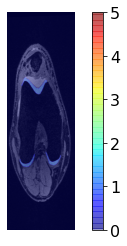

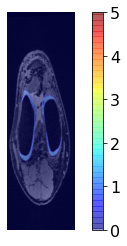

In [212]:
idx_slice_list = [50, 80, 95, 110] # slices to plot
idx_slice_list = [250, 280]

ee1 = echo1.volume
mm = mask.volume
print(mm.shape)

# added this outside loop
mm = np.rot90(mm, k=3, axes=(0,1))
mm = np.fliplr(mm)

for idx_slice in idx_slice_list:

#     e1_s = ee1[:,:,idx_slice]
#     m_s = mm[:,:,idx_slice]
    e1_s = ee1[idx_slice,:,:]
    m_s = mm[idx_slice,:,:]
    
    plt.imshow(e1_s, cmap='gray')
    plt.imshow(m_s, cmap='jet', clim=(0,5), alpha=0.4)
    plt.colorbar()
    plt.axis('off')
    plt.show()

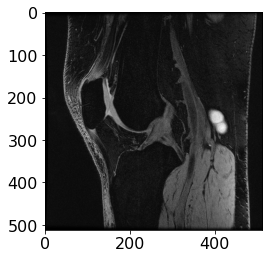

In [232]:
id_ = '005'
path_mtr = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/MTR_{}/'

ds = pydicom.dcmread(path_mtr_dir + 'I167.dcm')
arr = ds.pixel_array

plt.imshow(arr,cmap='gray')

In [152]:
y = np.bincount(mask_.flatten())
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[      0, 1620513],
       [      1,   17887]])